# Creating Toy Datasets from Materials Project Systematically

## Download Element Data (to save time)

In [17]:
from mp_api.client import MPRester
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
path_data = Path("./data")
path_data.mkdir(exist_ok=True)
path_elements = path_data/"mp_elements_dict.json"
API_KEY = "YOUR_KEY_HERE"

In [2]:
# with MPRester(API_KEY) as mpr:
#         docs = mpr.materials.summary.search(fields=["material_id", "elements"],)

In [3]:
if not path_elements.exists():  
    with MPRester(API_KEY) as mpr:
        docs = mpr.materials.summary.search(fields=["material_id", "elements", "deprecated"])
    
    mp_elements = {}
    for doc in docs:
        mp_elements[doc.material_id.string] = [element.number for element in doc.elements if not doc.deprecated]
        if doc.deprecated != False:
            print(doc.deprecated)
    
    with open(path_elements, 'w') as f: 
        json.dump(mp_elements, f)
else:
    with open(path_elements, 'r') as f: 
        mp_elements = json.load(f)

## Element Distribution Analysis

In [4]:
cutoff_element = 18 # Argon (two rows of periodic table)

materials_by_element = {}

for element in range(1, cutoff_element+1):
    
    materials_by_element[element] = []
    
    for (mp_id, elements) in mp_elements.items():
        if element in elements:
            materials_by_element[element].append(mp_id)
    
counts = {element: len(mp_ids) for element, mp_ids in materials_by_element.items()}
counts

{1: 10449,
 2: 8,
 3: 21761,
 4: 1189,
 5: 6370,
 6: 9083,
 7: 11442,
 8: 82406,
 9: 12136,
 10: 1,
 11: 12873,
 12: 19084,
 13: 7805,
 14: 12758,
 15: 16913,
 16: 15397,
 17: 6425,
 18: 2}

### Investigation

According to MP website 10,394 materials contain H; 8 He; 21,686 Li

In [5]:
with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        elements=["H"], fields=["material_id", "formula_pretty"]
    )
    mpid_formula_dict = {
        doc.material_id: doc.formula_pretty for doc in docs
    }

Retrieving SummaryDoc documents:   0%|          | 0/10394 [00:00<?, ?it/s]

In [6]:
len(docs)

10394

In [7]:
element = 9
for id in materials_by_element[element]:
    if not (element in mp_elements[id]):
        print(mp_elements[id].elements)

In [8]:
h_ids = [id.string for id in mpid_formula_dict.keys()]

In [9]:
[id for id in materials_by_element[1] if not (id in h_ids)]

['mp-697915',
 'mp-1187975',
 'mp-632667',
 'mp-634930',
 'mp-634751',
 'mp-864603',
 'mp-625103',
 'mp-626421',
 'mp-632348',
 'mp-1070852',
 'mp-2646948',
 'mp-1025273',
 'mp-1103732',
 'mp-626413',
 'mp-643108',
 'mp-1207586',
 'mp-740759',
 'mp-1206323',
 'mp-1018646',
 'mp-1018647',
 'mp-1187892',
 'mp-1207571',
 'mp-1207559',
 'mp-979964',
 'mp-1195507',
 'mp-1198634',
 'mp-1105386',
 'mp-1216487',
 'mp-643246',
 'mp-1195012',
 'mp-1195544',
 'mp-643071',
 'mp-1203501',
 'mp-1202946',
 'mp-1200022',
 'mp-705525',
 'mp-555985',
 'mp-1202633',
 'mp-1202882',
 'mp-1198247',
 'mp-1238179',
 'mp-1200794',
 'mp-1191250',
 'mp-697925',
 'mp-699393',
 'mp-1212344',
 'mp-722346',
 'mp-1203140',
 'mp-1200555',
 'mp-1202119',
 'mp-1193866',
 'mp-1190437',
 'mp-1198865',
 'mp-1200481',
 'mp-1200272']

In [10]:
"mp-697915"

'mp-697915'

In [11]:
len([id for id in materials_by_element[1] if not (id in h_ids)])

55

In [12]:
with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        material_ids=[id for id in materials_by_element[1] if not (id in h_ids)]
    )

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

## Continuing
Let's get the "target" distribution

In [13]:
num_materials = 10000
num_elements = cutoff_element
max_samples = num_materials // num_elements

In [14]:
targets = {element: min(max_samples, counts[element]) for element in range(1, cutoff_element+1)}

([<matplotlib.axis.XTick at 0x736007e05b20>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18')])

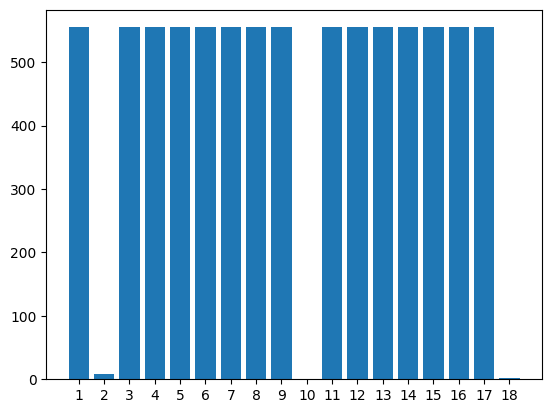

In [15]:
plt.bar(range(len(targets)), targets.values())
plt.xticks(range(len(targets)), list(targets.keys()))

In [23]:
for element in targets.keys():
    print(np.random.choice(materials_by_element[element], size=targets[element], replace=False))

['mp-722977' 'mp-849450' 'mp-690785' 'mp-1191351' 'mp-698522' 'mp-707866'
 'mp-744710' 'mp-740736' 'mp-1080238' 'mp-977298' 'mp-769159' 'mp-541423'
 'mp-1195275' 'mp-1195209' 'mp-24099' 'mp-1220990' 'mp-1201174'
 'mp-1221166' 'mp-720868' 'mp-1210781' 'mp-1198207' 'mp-1222086'
 'mp-1196378' 'mp-1196152' 'mp-1210396' 'mp-721617' 'mp-699412'
 'mp-643458' 'mp-1180984' 'mp-1197326' 'mp-644318' 'mp-707459' 'mp-733840'
 'mp-745107' 'mp-1202694' 'mp-1206375' 'mp-1199989' 'mp-1195839'
 'mp-1234626' 'mp-735514' 'mp-706913' 'mp-1190805' 'mp-27990' 'mp-722906'
 'mp-1213332' 'mp-643656' 'mp-1235056' 'mp-977573' 'mp-505245' 'mp-24811'
 'mp-722910' 'mp-643005' 'mp-696762' 'mp-1194478' 'mp-560734' 'mp-1247922'
 'mp-734495' 'mp-1202349' 'mp-23948' 'mp-1201601' 'mp-1199765' 'mp-768231'
 'mp-542129' 'mp-744689' 'mp-1233062' 'mp-601396' 'mp-1235564'
 'mp-1235551' 'mp-1196732' 'mp-1233049' 'mp-1197534' 'mp-1194398'
 'mp-626201' 'mp-1202482' 'mp-560730' 'mp-1214670' 'mp-24784' 'mp-1205145'
 'mp-861531' 'mp-